In [22]:
# Import Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from pprint import pprint
import yfinance as yf
import calendar
from datetime import datetime

from FREDAPI_Resources import get_interest_data
from Common_Stockdata import get_stock_data

# Import the API key
from api_keys import alpha_vantage_api_key, bls_api_key, fred_api_key
from fredapi import Fred # https://pypi.org/project/fredapi/  https://cran.r-project.org/web/packages/eFRED/vignettes/FetchingDataFromFRED.html

## CREATING A REQUESTS
Using yf and FREDAPI aquire the monthly Interest Rates and Profits over 10 years (2014-2024)

For this segment, we will make our request to the FRED API and yf API for data in the form of a json and dataframe respectively, please
ensure you have edited the api_keys.py file to have your unique FRED key
###### Most of this section has been done by Bailey

In [23]:
# Request stock dataframe from Common_Stockdata.py
stock_info_df = get_stock_data()
stock_info_df

,Date,Open,High,Low,Close,Volume,Year,Month_Number
1088,2019-12-31,211.62,212.7600,211.2000,212.61,18201585,2019,12
1089,2019-12-30,213.50,213.6300,211.1600,212.21,21829913,2019,12
1090,2019-12-27,214.54,214.5600,213.0400,213.61,18142239,2019,12
1091,2019-12-26,212.26,213.8100,212.2300,213.79,17159310,2019,12
1092,2019-12-24,212.00,212.0900,211.4400,211.92,7089020,2019,12
...,...,...,...,...,...,...,...,...
3599,2010-01-08,46.04,46.5500,45.9300,46.55,88886600,2010,1
3600,2010-01-07,46.20,46.2700,45.9200,46.17,77094100,2010,1
3601,2010-01-06,46.39,46.5500,46.0700,46.14,96033000,2010,1
3602,2010-01-05,46.38,46.5000,46.1600,46.42,62935600,2010,1


In [24]:
# Fred API Dataframe
interest_data = get_interest_data()
interest_data

,Date,Interest_Rate,Year,Month,Day
0,2010-01-01,0.11,2010,1.0,01
1,2010-02-01,0.13,2010,2.0,01
2,2010-03-01,0.16,2010,3.0,01
3,2010-04-01,0.20,2010,4.0,01
4,2010-05-01,0.20,2010,5.0,01
...,...,...,...,...,...
115,2019-08-01,2.13,2019,8.0,01
116,2019-09-01,2.04,2019,9.0,01
117,2019-10-01,1.83,2019,10.0,01
118,2019-11-01,1.55,2019,11.0,01


## Assemble the Dataframes ready for merging
In this segment we will take our raw data from our requests and sort it into monthly data ready to be all merged together into a complete frame

In [25]:
## Using Common_Stockdata.py to make a new dataframe for Monthly Profits
# Date, Month Column creation by using Date
stock_info_df['Year'] = stock_info_df['Date'].dt.year
stock_info_df['Month_Number'] = stock_info_df['Date'].dt.month

# Close price for each Year, Month
monthly_data = stock_info_df.groupby(['Year', 'Month_Number'])
last_close = monthly_data['Close'].last().reset_index()
first_open = monthly_data["Open"].first().reset_index()
profit_monthly = last_close['Close'] - first_open['Open']
profit_df = pd.DataFrame({'profit_monthly': profit_monthly})

# dataFrame creation
monthly_profit_df = pd.DataFrame({
                                    'Year': last_close['Year'],
                                    'Month_Number': last_close['Month_Number'],
                                    'Monthly_Profit': profit_df['profit_monthly']
                                })

# Generate month numbers (1-12)
month_numbers = list(range(1, 13))

# Use list comprehension to map month numbers to month names
month_names = [calendar.month_name[month] for month in month_numbers]

# Create the DataFrame
month_df = pd.DataFrame({
                            'Month_Number': month_numbers,
                            'Month': month_names
                        })

# Merge the DataFrames on 'Month' from monthly_profit_df and 'Month Number' from month_df
monthly_profit_merge_df = pd.merge(monthly_profit_df, month_df, left_on='Month_Number', right_on='Month_Number', how='left')
monthly_profit_final_df = monthly_profit_merge_df[["Year", "Month", "Monthly_Profit"]]


In [26]:
# Merging Fred frame with Month names
merged_interest_df = pd.merge(interest_data, month_df, left_on="Month",right_on="Month_Number", how="left")
same_merged_interest_df = merged_interest_df[['Year', "Month_y", "Interest_Rate"]]
same_merged_interest_df.loc[:, "Year"] = same_merged_interest_df["Year"].astype(float)
same_merged_interest_df

,Year,Month_y,Interest_Rate
0,2010.0,January,0.11
1,2010.0,February,0.13
2,2010.0,March,0.16
3,2010.0,April,0.20
4,2010.0,May,0.20
...,...,...,...
115,2019.0,August,2.13
116,2019.0,September,2.04
117,2019.0,October,1.83
118,2019.0,November,1.55


In [27]:
# Creating a new merged dataframe of the two separate ones
same_month_df = pd.merge(same_merged_interest_df, monthly_profit_final_df, left_on=["Year", "Month_y"], right_on=["Year", "Month"], how="left")
same_month_df = same_month_df[["Year", "Month", "Interest_Rate", "Monthly_Profit"]]
same_month_df

,Year,Month,Interest_Rate,Monthly_Profit
0,2010.0,January,0.11,2.52
1,2010.0,February,0.13,-1.34
2,2010.0,March,0.16,-2.82
3,2010.0,April,0.20,-2.05
4,2010.0,May,0.20,3.99
...,...,...,...,...
115,2019.0,August,2.13,1.22
116,2019.0,September,2.04,-2.14
117,2019.0,October,1.83,-10.29
118,2019.0,November,1.55,-6.65


## Creating the scatters
Now that we have all of our data and its neatly organised, we can create a scatterplot for:

1. Monthly Profits compared to the interest rates one month after that month

In [28]:
# Shifting the month column down one to be aligned with next months rates (eg the profits of Feb compared with Interest rates of March)
same_month_df[["Month_After", "Interest_After"]] = same_month_df[["Month", 'Interest_Rate']].shift(-1)
monthafter_df = same_month_df[["Year", "Month_After", "Interest_After", "Monthly_Profit"]]
month_after_df = monthafter_df.drop(monthafter_df.index[-1])
month_after_df

,Year,Month_After,Interest_After,Monthly_Profit
0,2010.0,February,0.13,2.52
1,2010.0,March,0.16,-1.34
2,2010.0,April,0.20,-2.82
3,2010.0,May,0.20,-2.05
4,2010.0,June,0.18,3.99
...,...,...,...,...
114,2019.0,August,2.13,-5.04
115,2019.0,September,2.04,1.22
116,2019.0,October,1.83,-2.14
117,2019.0,November,1.55,-10.29


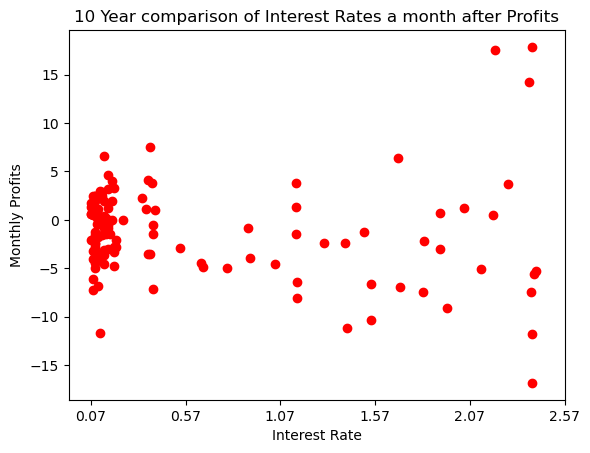

In [29]:
ma_int_rate = month_after_df["Interest_After"].tolist()
ma_month_prof = month_after_df["Monthly_Profit"].tolist()

ma_int_rate_float = [float(val) for val in ma_int_rate]
ma_month_prof_float = [float(val) for val in ma_month_prof]

plt.scatter(ma_int_rate_float, ma_month_prof_float, color='red', label="Dataset1")
plt.xticks(np.arange(min(ma_int_rate_float), max(ma_int_rate_float)+0.5, 0.5))
plt.xlabel('Interest Rate')
plt.ylabel('Monthly Profits')
plt.title('10 Year comparison of Interest Rates a month after Profits')
plt.savefig("output_data/InterestGraph1.png")

2. Monthly Profits compared to the interest rates of the current month

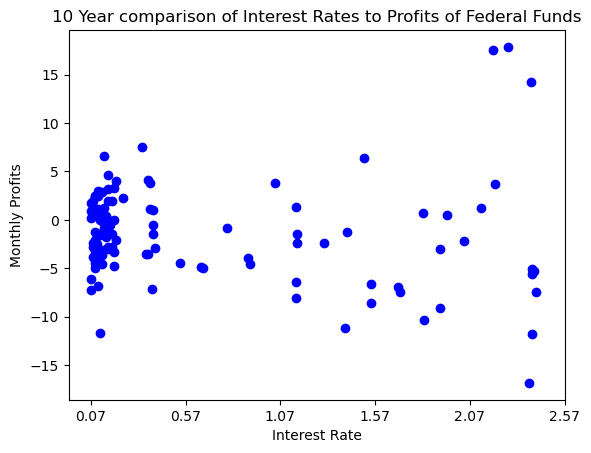

In [30]:
# Scatter for same month
# Changing values to lists and floats to help neaten the xticks and the scatter
int_rate = same_month_df["Interest_Rate"].tolist()
month_prof = same_month_df["Monthly_Profit"].tolist()

int_rate_float = [float(val) for val in int_rate]
month_prof_float = [float(val) for val in month_prof]

plt.scatter(int_rate_float, month_prof_float, color='blue', label="Dataset2")
plt.xticks(np.arange(min(int_rate_float), max(int_rate_float)+0.5, 0.5))
plt.xlabel('Interest Rate')
plt.ylabel('Monthly Profits')
plt.title('10 Year comparison of Interest Rates to Profits of Federal Funds')
plt.savefig("output_data/InterestGraph2.png")

3. Monthly Profits compared to the interest rates one month prior to that month

In [31]:
# Shifting the month column up one to be aligned with prior months rates (eg the profits of Feb compared with Interest rates of Jan)
same_month_df[["Month_Before", "Interest_Before"]] = same_month_df[["Month", 'Interest_Rate']].shift(1)
monthbefore_df = same_month_df[["Year", "Month_Before", "Interest_Before", "Monthly_Profit"]]
month_before_df = monthbefore_df.drop(monthbefore_df.index[0])
month_before_df

,Year,Month_Before,Interest_Before,Monthly_Profit
1,2010.0,January,0.11,-1.34
2,2010.0,February,0.13,-2.82
3,2010.0,March,0.16,-2.05
4,2010.0,April,0.20,3.99
5,2010.0,May,0.20,1.95
...,...,...,...,...
115,2019.0,July,2.40,1.22
116,2019.0,August,2.13,-2.14
117,2019.0,September,2.04,-10.29
118,2019.0,October,1.83,-6.65


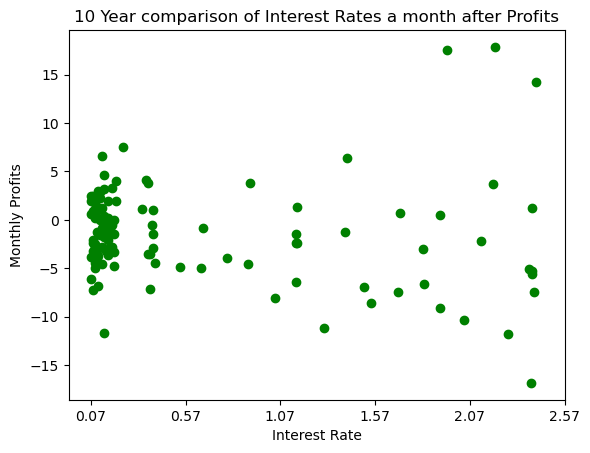

In [32]:
mb_int_rate = month_before_df["Interest_Before"].tolist()
mb_month_prof = month_before_df["Monthly_Profit"].tolist()

mb_int_rate_float = [float(val) for val in mb_int_rate]
mb_month_prof_float = [float(val) for val in mb_month_prof]

plt.scatter(mb_int_rate_float, mb_month_prof_float, color='green', label="Dataset1")
plt.xticks(np.arange(min(mb_int_rate_float), max(mb_int_rate_float)+0.5, 0.5))
plt.xlabel('Interest Rate')
plt.ylabel('Monthly Profits')
plt.title('10 Year comparison of Interest Rates a month after Profits')
plt.savefig("output_data/InterestGraph3.png")

All Scatters compared to one another

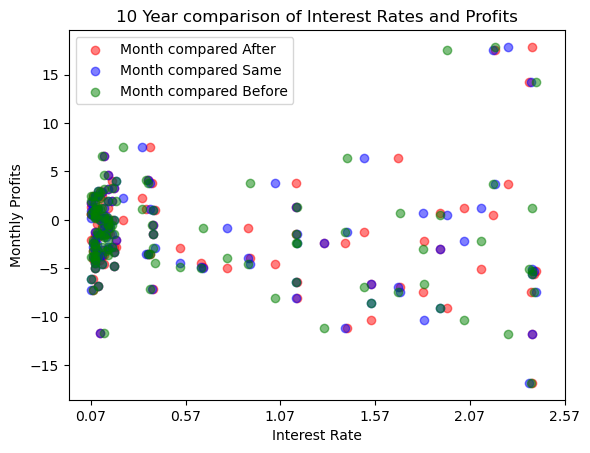

In [33]:
plt.scatter(ma_int_rate_float, ma_month_prof_float, color='red', label="Month compared After", alpha=0.5)
plt.xticks(np.arange(min(ma_int_rate_float), max(ma_int_rate_float)+0.5, 0.5))
plt.scatter(int_rate_float, month_prof_float, color='blue', label="Month compared Same", alpha=0.5)
plt.xticks(np.arange(min(int_rate_float), max(int_rate_float)+0.5, 0.5))
plt.scatter(mb_int_rate_float, mb_month_prof_float, color='green', label="Month compared Before", alpha=0.5)
plt.xticks(np.arange(min(mb_int_rate_float), max(mb_int_rate_float)+0.5, 0.5))

plt.xlabel('Interest Rate')
plt.ylabel('Monthly Profits')
plt.title('10 Year comparison of Interest Rates and Profits')
plt.legend()
plt.savefig("output_data/InterestGraph4.png")
plt.show()